In [677]:
# Driver

# Küldjünk valami csomagot a workernek

import numpy as np
import requests
import codecs
import pickle
import joblib
import json
import time
import os
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn import datasets
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# beállítunk néhány paraméter ami amit később használunk
# ezeket az értékeket sajnos a Driver oldalon is ki kell számolnunk, ha úgy csináljuk, hogy a modelt küldjük át
# fontos, hogy számos paraméter szinkronizálva legyen, különben ami model itt előáll az a Worker oldalon eltörik
arch = (2,2)                                # <-- nn(arch)
window = 21                                 # <-- bementi változók száma
nRowsRead = 9999                            # <-- ez lehet alapján csinálunk modelt, de lehet más is mint odaát
threshold = -1.0                            # <-- a trader parametére

# elő kell állítani a túloldali adatsorral azonos szart np.[970, 20] és np[970]
x_train = np.ones((970, window))
y_train = np.zeros(970)
print(x_train.shape)
print(y_train.shape)
clf = MLPRegressor(hidden_layer_sizes=arch, max_iter=3, shuffle=False, activation='tanh', random_state=1)
clf.fit(x_train, y_train)

# ---------------------------------------------------------------------------
# Ugyan ez a Joblib használatával (ez valami filét is csiál rendesen a diskre)
# from joblib import dump, load
joblib.dump(clf, 'model.joblib')         # <-- elmenjük
clf = joblib.load('model.joblib')        # <-- betöltjük

# ---------------------------------------------------------------------------
# nem a pickle-t használom, hanem a joblibet, de itt hagyom
# s = pickle.dumps(clf)     # <-- csinálunk belőe bytot
# print(type(s))            # <-- ez byte valahogy biztosan át lehet küldeni.
# clf = pickle.loads(s)    # <-- betöltjük
# clf.predict(x_train)


# ---------------------------------------------------------------------------


# ---------------------------------------------------------------------------


# Valamiért újra indítás után nem müködnek de futnak a workeren mégis kill ---> újrainditás kellett terminálból
# worker_address = 'http://192.168.0.54:8080'
# worker_address = 'http://192.168.0.32:8080'
worker_address = 'http://192.168.0.247:8080'
driver_ip = 'http://192.168.0.114:8080'
worker_id = 234



# ---------------------------------------------------------------------------


# Setuppolni kell a paramétereket
# request_params = 'worker_id=' + (str)(worker_id) + '&nRowsRead=' + (str)(nRowsRead) + '&' + 'window=' + (str)(window) + '&' + 'threshold=' + (str)(threshold)

request_params = 'driver_ip=' + (str)(driver_ip) + '&worker_id=' + (str)(worker_id) + '&nRowsRead=' + (str)(nRowsRead) + '&' + 'window=' + (str)(window) + '&' + 'threshold=' + (str)(threshold)

print(request_params)
# resp = requests.get('http://192.168.0.247:8080/setup?nRowsRead=2998&window=20&threshold=-1000')
# resp = requests.get('http://192.168.0.247:8080/setup?' + request_params)
resp = requests.get(worker_address + '/setup?' + request_params)
print('setup      ', resp)

# Ezzel simán meghívjuk a Worker INITIALIZE REST API Végpontját
resp = requests.get(worker_address + '/initilaize')
print('initialize ', resp)

# Ezzel a módszerrel lehet átküldeni neki a joblib model filét
uploadResultUrl = worker_address + '/uploader'
filePath = "model.joblib"
fileFp = open(filePath, 'rb')
fileInfoDict = {
    "file": fileFp,
    "model_id": '99999',                                    # <-- dummy értéket kap
}
metaInfoDict = {'id': '99999'}
resp = requests.post(uploadResultUrl, files=fileInfoDict, json=metaInfoDict)
print('uploader   ', resp)                                # <-- ez nagyon jó ha <Response [200]> mert akkor átment a file
print(fileInfoDict)
print(metaInfoDict)

# Átküldök egy értéket a Workernek
resp = requests.get(worker_address + '/testpoint?value=123456789')
print('testpoint  ', resp)


(970, 21)
(970,)
driver_ip=http://192.168.0.114:8080&worker_id=234&nRowsRead=9999&window=21&threshold=-1.0
setup       <Response [200]>
initialize  <Response [200]>
uploader    <Response [200]>
{'file': <_io.BufferedReader name='model.joblib'>, 'model_id': '99999'}
{'id': '99999'}
testpoint   <Response [200]>


In [678]:
# Terhelés, testpoint REST API-t
milliseconds = 100
wait = 0.001 * milliseconds

for i in range(5):
    time.sleep(wait)
    # Átküldök egy értéket a Workernek
    value = (str)(i*123456)
    resp = requests.get(worker_address + '/testpoint?value=' + value)
    print(i, 'testpoint  ', resp)

0 testpoint   <Response [200]>
1 testpoint   <Response [200]>
2 testpoint   <Response [200]>
3 testpoint   <Response [200]>
4 testpoint   <Response [200]>


In [679]:
# Terhelés, küldjük el többször csak a modell, hívjuk az upload REST API-t
milliseconds = 100
wait = 0.001 * milliseconds

for i in range(5):
    time.sleep(wait)
    # Ezzel a módszerrel lehet átküldeni neki a joblib model filét
    uploadResultUrl = worker_address + '/uploader'
    filePath = "model.joblib"
    fileFp = open(filePath, 'rb')
    fileInfoDict = {
        "file": fileFp,
        "model_id": 99999,                                    # <-- dummy értéket kap
    }
    resp = requests.post(uploadResultUrl, files=fileInfoDict)
    print(i, 'uploader   ', resp)

0 uploader    <Response [200]>
1 uploader    <Response [200]>
2 uploader    <Response [200]>
3 uploader    <Response [200]>
4 uploader    <Response [200]>


In [680]:
# API arra, hogy csináljon egy Git Pull-t majd újraindítom
# resp = requests.get(worker_address + '/update')
# print('update     ', resp)


## Most a helyi Driver Flask programhoz írok megszolítókat

Fontos az egyes lépések sorrendje.

In [681]:

driver_address = 'http://192.168.0.114:8080'


# Átküldök egy értéket a Drivernek
resp = requests.get(driver_address + '/testpoint?value=987654321')
print('testpoint  ', resp)



testpoint   <Response [200]>


In [682]:

# A Driver hívja a Workerek testpoint API-t
resp = requests.get(driver_address + '/calltestpoint')
print('calltestpoint  ', resp)


calltestpoint   <Response [200]>


In [742]:

generation = 5000      # 300
factor     = 10
dummy      = 11

# A Driver setupja
request_params = 'generation=' + (str)(generation) + '&' + 'factor=' + (str)(factor) + '&' + 'dummy=' + (str)(dummy)
print(request_params)
resp = requests.get(driver_address + '/setup?' + request_params)
print('setup         ', resp)


generation=5000&factor=10&dummy=11
setup          <Response [200]>


In [743]:

# A Driver inicializációja (itt áll elő egy csomó belső változó amit később használok)

_nRowsRead = 90000

request_params = '_nRowsRead=' + (str)(_nRowsRead)
resp = requests.get(driver_address + '/initilaize?' + request_params)
print('initilaize     ', resp)


initilaize      <Response [200]>


In [744]:

# A workerek setupja
resp = requests.get(driver_address + '/setupworkers')
print('setupworkers   ', resp)


setupworkers    <Response [200]>


In [745]:

# A workerek inicializációja
resp = requests.get(driver_address + '/initializeworkers')
print('initializeworkers ', resp)
print(resp.text)


initializeworkers  <Response [200]>
('[OK] worker', 'http://192.168.0.54:8080/', 'setup', 200)('[OK] worker', 'http://192.168.0.32:8080/', 'setup', 200)('[OK] worker', 'http://192.168.0.247:8080/', 'setup', 200)


In [746]:

# Most azt kell tesztelnem, hogy a Workerek miután kiértékelték az eredményt
# visszaküldik-e a Drivernek
# és az fogadja-e?


In [747]:

# Teszt csomag küldés a Workereknek, hogy kiszámolják-e amit ki kell
resp = requests.get(driver_address + '/testworkerscalc')
print('testworkerscalc   ', resp)


testworkerscalc    <Response [200]>


In [748]:

# Terhelés teszt törölhető lesz
milliseconds = 100
wait = 0.001 * milliseconds
time.sleep(1)

# for i in range(5):
#     time.sleep(wait)
    # Ez a végpont az összes workernek elküldi ugyan azt a modelt
#     resp = requests.get(driver_address + '/testworkerscalc')
#     print('testworkerscalc   ', resp)
    

In [749]:
# Visszakapja az adatokat
# most akkor a drivert kell egy picit masziroznom,
# főként a mutátor logikát
# A testcalc API-t hagyom, az jó arra, hogy teszteljük, hogy valóban minden Worker ugyan azt az eredményt adja-e vissza,
# ha azonos modelt kapnak.

# Csinálni kell egy új apit, mondjuk 'eval', ami csinál egy modelt, randomizálja, visszakapja az eredményt és kiválasztja


# Vigyázni kell,
# Az elöző cellából visszamaradt és a háttérben még futó számítások nem kívánt beküldéseket eredményezhetnek a következő
# cella futásában, ezért meg kell gyöződni arról, hogy minden korábbi futás válasza beérkezett-e és csak utána indítani
# a következő cellát.

# Meg kell várni míg minden korábbi lefutott és bevárni a válaszokat mert ez jelenleg még okozhat hibát (bug)
# dolgozom rajta (ToDo)

In [750]:

# Meg kell várni míg minden korábbi lefutott és bevárni a válaszokat mert ez jelenleg még okozhat hibát (bug)
# dolgozom rajta (ToDo)


# Dev2
resp = requests.get(driver_address + '/evolution2')
print('evolution      ', resp)
print(type(resp))



evolution       <Response [200]>
<class 'requests.models.Response'>


In [726]:
print("\033[48;5;236m\033[38;5;231mStack \033[38;5;208mAbuse\033[0;0m")

Stack Abuse


In [739]:
# resp.json()

In [751]:
lst = resp.json()
generation_best_score = [float(i) for i in lst]        # <-- list(str) -> list(float)

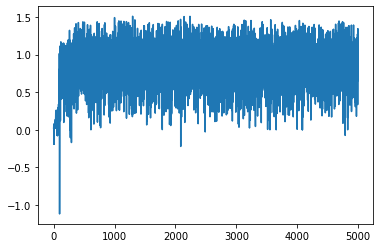

In [752]:
plt.plot(generation_best_score)
plt.show()

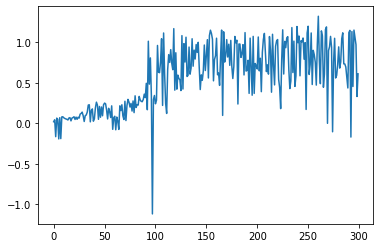

In [741]:
plt.plot(generation_best_score)
plt.show()

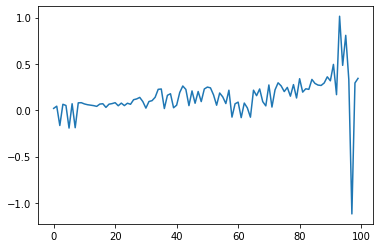

In [729]:
plt.plot(generation_best_score)
plt.show()

In [754]:
# Egy JSON-t akarok visszakapni, ezért csináltam rá egy API-t
resp = requests.get(driver_address + '/tmp')
print('tmp         ', resp)
print(type(resp))
print(resp.text)

tmp          <Response [404]>
<class 'requests.models.Response'>
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>

